<a href="https://colab.research.google.com/github/PratyushJha254/BTP/blob/main/lattice_ani_Binder_cumu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install ffmpeg-python

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Load the .npz file
data = np.load('LRIM_FT_64L_modified_data.npz', allow_pickle= True)

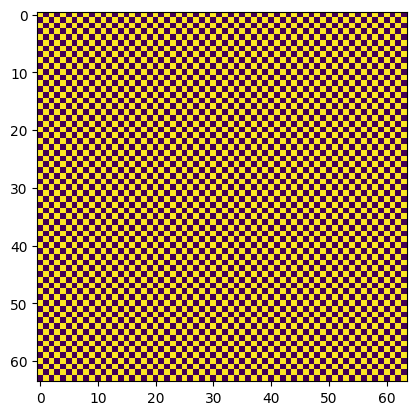

In [ ]:
plt.imshow(data["X"][3809])

In [ ]:
print(data)

NpzFile 'data_64NN_ferro_noshuffle_L.npz' with keys: X, y


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

def create_lattice_animation(lattices, interval=50, save_path='animation.mp4'):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))

    # Set up the plot
    im = ax.imshow(lattices[0])
    plt.colorbar(im)

    def animate(frame):
        # Clear previous frame
        ax.clear()
        # Plot new frame
        im = ax.imshow(lattices[frame])
        ax.set_title(f'Frame {frame}')
        return [im]

    # Create animation
    ani = FuncAnimation(
        fig,
        animate,
        frames=len(lattices),
        interval=interval,  # in milliseconds
        repeat=True
    )

    # Save animation
    writer = animation.FFMpegWriter(fps=1, bitrate=2000)
    ani.save(save_path, writer=writer)

    plt.close()
    return ani

# Usage example:
# animation = create_lattice_animation(lattice_list)

In [ ]:
ani = create_lattice_animation(data["X"],save_path = "./LRIM_64FT_nullified.mp4")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
data = np.load('LRIM_FT_64L_data_6_11_modified.npz', allow_pickle= True)
copy_data = data


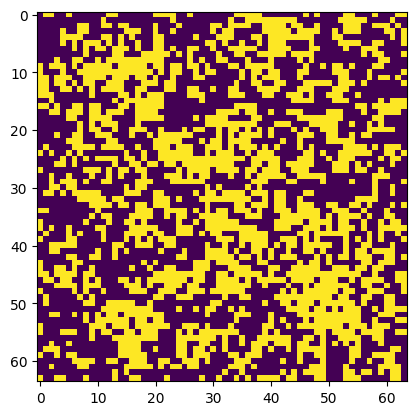

In [ ]:
plt.imshow(data["X"][37])

In [ ]:
copy_data["X"][29] = data["X"][29]*(-1)

SyntaxError: invalid decimal literal (<ipython-input-65-e7b83c4ba798>, line 1)

In [ ]:
np.savez_compressed("LRIM_FT_64L_data_6_11_rectified.npz", X = copy_data["X"], y = data["y"])

Starting data processing...

Processing L = 8
Found 150 configurations
Temperature range: 0.500 to 15.400

Processing L = 16
Found 150 configurations
Temperature range: 0.500 to 15.400

Processing L = 24
Found 150 configurations
Temperature range: 0.500 to 15.400

Processing L = 32
Found 150 configurations
Temperature range: 0.500 to 15.400

Processing L = 48
Found 150 configurations
Temperature range: 0.500 to 15.400

Processing L = 64
Found 150 configurations
Temperature range: 0.500 to 15.400

Calculating Binder cumulants...


<ipython-input-5-41faeca27d3b>:75: RuntimeWarning: invalid value encountered in scalar divide
  UL = 1.0 - m4_avg/(3.0 * m2_avg**2)


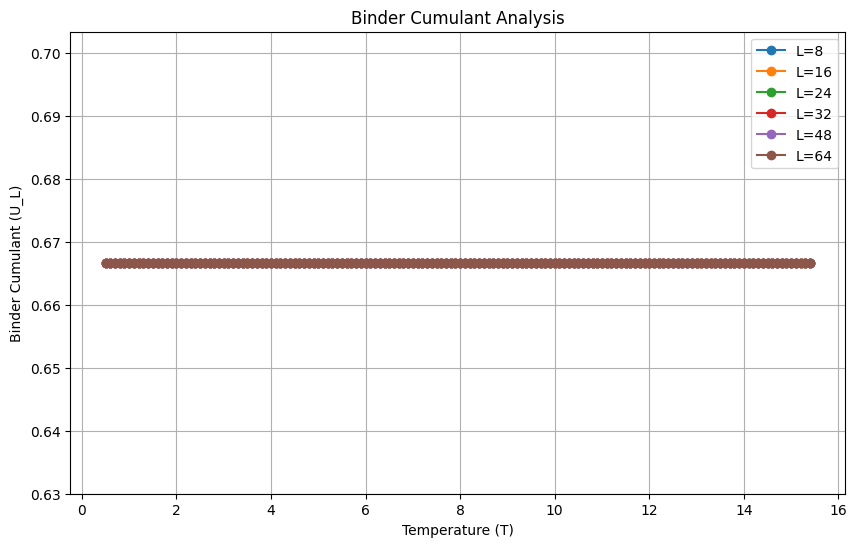


Estimating critical temperature...

Results:
Critical temperature (Tc) = 11.7374 ± 2.6668
Universal Binder cumulant (U*) = 0.6667 ± 0.0000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import os

class CompleteBinder:
    def __init__(self):
        """Initialize analysis for multiple system sizes."""
        self.system_sizes = []
        self.temperatures = set()  # Using set for unique temperatures
        self.magnetizations = {}
        self.binder_data = {}

    def process_single_file(self, filename):
        """
        Process a single npz file containing lattice configurations.

        Parameters:
        -----------
        filename : str
            Path to npz file containing X (lattice) and y (temperature) data
        """
        data = np.load(filename)
        X = data['X']
        y = data['y']

        # Get system size from lattice dimension
        L = X.shape[1]
        print(f"\nProcessing L = {L}")
        print(f"Found {len(X)} configurations")
        print(f"Temperature range: {np.min(y):.3f} to {np.max(y):.3f}")

        # Initialize storage for this system size
        if L not in self.system_sizes:
            self.system_sizes.append(L)
            self.magnetizations[L] = {}

        # Calculate magnetizations and organize by temperature
        unique_temps = np.unique(y)
        self.temperatures.update(unique_temps)

        for T in unique_temps:
            config_indices = np.where(y == T)[0]
            magnetizations = np.array([np.mean(X[i]) for i in config_indices])
            self.magnetizations[L][T] = magnetizations

    def process_all_files(self, filenames):
        """
        Process multiple npz files for different system sizes.

        Parameters:
        -----------
        filenames : list
            List of npz filenames to process
        """
        print("Starting data processing...")
        for filename in filenames:
            self.process_single_file(filename)

        # Convert temperature set to sorted list
        self.temperatures = sorted(list(self.temperatures))
        self.system_sizes.sort()

    def calculate_binder_cumulants(self):
        """Calculate Binder cumulants for all system sizes and temperatures."""
        print("\nCalculating Binder cumulants...")

        for L in self.system_sizes:
            self.binder_data[L] = []
            for T in self.temperatures:
                if T in self.magnetizations[L]:
                    m = self.magnetizations[L][T]
                    m2_avg = np.mean(m**2)
                    m4_avg = np.mean(m**4)
                    UL = 1.0 - m4_avg/(3.0 * m2_avg**2)
                    self.binder_data[L].append(UL)
                else:
                    self.binder_data[L].append(np.nan)

    def plot_analysis(self, save_path=None):
        """
        Create comprehensive plots of the analysis.

        Parameters:
        -----------
        save_path : str, optional
            Directory to save the plots
        """
        # Create Binder cumulant plot
        plt.figure(figsize=(10, 6))
        for L in self.system_sizes:
            plt.plot(self.temperatures, self.binder_data[L],
                    'o-', label=f'L={L}')

        plt.xlabel('Temperature (T)')
        plt.ylabel('Binder Cumulant (U_L)')
        plt.title('Binder Cumulant Analysis')
        plt.legend()
        plt.grid(True)

        if save_path:
            plt.savefig(os.path.join(save_path, 'binder_cumulants.png'))
        plt.show()

    def estimate_critical_temperature(self):
        """
        Estimate critical temperature from curve intersections.

        Returns:
        --------
        tuple : (Tc, Tc_err)
            Estimated critical temperature and its uncertainty
        """
        print("\nEstimating critical temperature...")
        intersection_temps = []
        intersection_UL = []

        # Find intersections between all pairs of system sizes
        for i, L1 in enumerate(self.system_sizes[:-1]):
            for L2 in self.system_sizes[i+1:]:
                # Create interpolation functions
                valid_indices = ~np.isnan(self.binder_data[L1]) & ~np.isnan(self.binder_data[L2])
                temps = np.array(self.temperatures)[valid_indices]
                UL1 = np.array(self.binder_data[L1])[valid_indices]
                UL2 = np.array(self.binder_data[L2])[valid_indices]

                if len(temps) > 3:  # Need at least 4 points for cubic interpolation
                    f1 = interp1d(temps, UL1, kind='cubic')
                    f2 = interp1d(temps, UL2, kind='cubic')

                    # Find intersection points
                    t_dense = np.linspace(temps[0], temps[-1], 1000)
                    diff = f1(t_dense) - f2(t_dense)

                    # Look for zero crossings
                    for j in range(len(t_dense)-1):
                        if diff[j] * diff[j+1] < 0:
                            t_cross = (t_dense[j] + t_dense[j+1])/2
                            intersection_temps.append(t_cross)
                            intersection_UL.append((f1(t_cross) + f2(t_cross))/2)

        if intersection_temps:
            Tc = np.mean(intersection_temps)
            Tc_err = np.std(intersection_temps)
            UL_star = np.mean(intersection_UL)
            UL_star_err = np.std(intersection_UL)

            print(f"\nResults:")
            print(f"Critical temperature (Tc) = {Tc:.4f} ± {Tc_err:.4f}")
            print(f"Universal Binder cumulant (U*) = {UL_star:.4f} ± {UL_star_err:.4f}")

            return Tc, Tc_err, UL_star, UL_star_err
        else:
            print("\nWarning: No intersections found!")
            return None, None, None, None

def run_complete_analysis(file_pattern, save_dir=None):
    """
    Run complete Binder cumulant analysis for multiple system sizes.

    Parameters:
    -----------
    file_pattern : str
        Pattern for npz filenames (e.g., "L{}_data.npz")
    save_dir : str, optional
        Directory to save results and plots
    """
    # Create list of available files
    system_sizes = [8,16,24,32,48,64]  # Adjust these to match your available sizes
    filenames = [file_pattern.format(L) for L in system_sizes]

    # Check file existence
    existing_files = [f for f in filenames if os.path.exists(f)]
    if not existing_files:
        raise FileNotFoundError("No data files found!")

    # Initialize and run analysis
    analyzer = CompleteBinder()
    analyzer.process_all_files(existing_files)
    analyzer.calculate_binder_cumulants()

    # Create plots
    analyzer.plot_analysis(save_dir)

    # Estimate critical temperature
    Tc, Tc_err, UL_star, UL_star_err = analyzer.estimate_critical_temperature()

    return analyzer, (Tc, Tc_err, UL_star, UL_star_err)

# Example usage:
if __name__ == "__main__":
    file_pattern = "LRIM_FT_{}L_modified_data.npz"  # Example: "L8_data.npz", "L16_data.npz", etc.
    save_directory = "binder_analysis_results_test"

    # Create save directory if it doesn't exist
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    try:
        # Run analysis
        analyzer, results = run_complete_analysis(file_pattern, save_directory)
        Tc, Tc_err, UL_star, UL_star_err = results

        # Save numerical results to file
        if Tc is not None:
            with open(os.path.join(save_directory, 'results.txt'), 'w') as f:
                f.write(f"Critical Temperature (Tc) = {Tc:.4f} ± {Tc_err:.4f}\n")
                f.write(f"Universal Binder Cumulant (U*) = {UL_star:.4f} ± {UL_star_err:.4f}\n")
                f.write(f"\nAnalyzed System Sizes: {analyzer.system_sizes}\n")
                f.write(f"Temperature Range: {min(analyzer.temperatures):.4f} to {max(analyzer.temperatures):.4f}\n")

    except Exception as e:
        print(f"Error during analysis: {str(e)}")


Processing L = 8

Processing L = 16

Processing L = 24

Processing L = 32

Processing L = 48

Processing L = 64


<ipython-input-8-58ac26803a55>:49: RuntimeWarning: invalid value encountered in scalar divide
  UL = 1.0 - m4_avg/(3.0 * m2_avg**2)


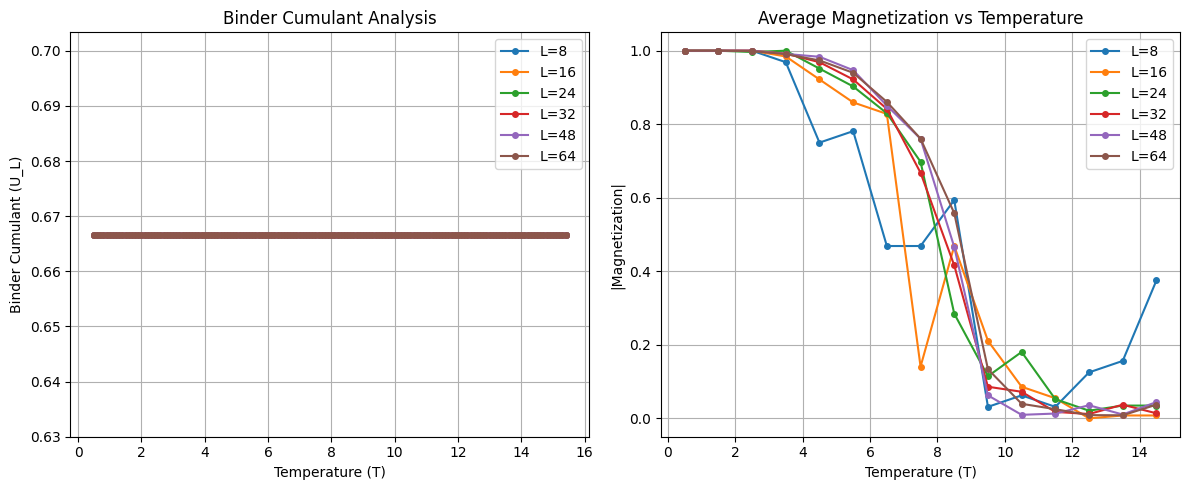

Critical temperature (Tc) = 9.4787 ± 3.5618
Universal Binder cumulant (U*) = 0.6667 ± 0.0000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import os

class CompleteBinder:
    def __init__(self):
        self.system_sizes = []
        self.temperatures = set()
        self.magnetizations = {}
        self.binder_data = {}

    def process_single_file(self, filename):
        data = np.load(filename)
        X = data['X']
        y = data['y']

        L = X.shape[1]
        print(f"\nProcessing L = {L}")

        if L not in self.system_sizes:
            self.system_sizes.append(L)
            self.magnetizations[L] = {}

        unique_temps = np.unique(y)
        self.temperatures.update(unique_temps)

        for T in unique_temps:
            config_indices = np.where(y == T)[0]
            # Use raw magnetization without absolute value for Binder calculation
            magnetizations = np.array([np.mean(X[i]) for i in config_indices])
            self.magnetizations[L][T] = magnetizations

    def process_all_files(self, filenames):
        for filename in filenames:
            self.process_single_file(filename)

        self.temperatures = sorted(list(self.temperatures))
        self.system_sizes.sort()

    def calculate_binder_cumulants(self):
        for L in self.system_sizes:
            self.binder_data[L] = []
            for T in self.temperatures:
                if T in self.magnetizations[L]:
                    m = self.magnetizations[L][T]
                    m2_avg = np.mean(m**2)
                    m4_avg = np.mean(m**4)
                    UL = 1.0 - m4_avg/(3.0 * m2_avg**2)
                    self.binder_data[L].append(UL)
                else:
                    self.binder_data[L].append(np.nan)

    def plot_analysis(self, save_path=None, thin_factor=10):
        plt.figure(figsize=(12, 5))

        # Plot 1: Binder cumulants
        plt.subplot(1, 2, 1)
        for L in self.system_sizes:
            plt.plot(self.temperatures, self.binder_data[L],
                    'o-', label=f'L={L}', markersize=4)

        plt.xlabel('Temperature (T)')
        plt.ylabel('Binder Cumulant (U_L)')
        plt.title('Binder Cumulant Analysis')
        plt.legend()
        plt.grid(True)

        # Plot 2: Magnetization with thinning
        plt.subplot(1, 2, 2)
        for L in self.system_sizes:
            avg_mag = []
            for T in self.temperatures:
                if T in self.magnetizations[L]:
                    # Take absolute value for magnetization plot
                    avg_mag.append(np.mean(np.abs(self.magnetizations[L][T])))
                else:
                    avg_mag.append(np.nan)

            # Thin the data for plotting
            temps_thin = self.temperatures[::thin_factor]
            mag_thin = np.array(avg_mag)[::thin_factor]

            plt.plot(temps_thin, mag_thin,
                    'o-', label=f'L={L}', markersize=4)

        plt.xlabel('Temperature (T)')
        plt.ylabel('|Magnetization|')
        plt.title('Average Magnetization vs Temperature')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        if save_path:
            plt.savefig(os.path.join(save_path, 'analysis_plots.png'), dpi=300, bbox_inches='tight')
        plt.show()

    def estimate_critical_temperature(self):
        intersection_temps = []
        intersection_UL = []

        for i, L1 in enumerate(self.system_sizes[:-1]):
            for L2 in self.system_sizes[i+1:]:
                valid_indices = ~np.isnan(self.binder_data[L1]) & ~np.isnan(self.binder_data[L2])
                temps = np.array(self.temperatures)[valid_indices]
                UL1 = np.array(self.binder_data[L1])[valid_indices]
                UL2 = np.array(self.binder_data[L2])[valid_indices]

                if len(temps) > 3:
                    f1 = interp1d(temps, UL1, kind='cubic')
                    f2 = interp1d(temps, UL2, kind='cubic')

                    t_dense = np.linspace(temps[0], temps[-1], 5000)
                    diff = f1(t_dense) - f2(t_dense)

                    for j in range(len(t_dense)-1):
                        if diff[j] * diff[j+1] < 0:
                            t_cross = (t_dense[j] + t_dense[j+1])/2
                            intersection_temps.append(t_cross)
                            intersection_UL.append((f1(t_cross) + f2(t_cross))/2)

        if intersection_temps:
            Tc = np.mean(intersection_temps)
            Tc_err = np.std(intersection_temps)
            UL_star = np.mean(intersection_UL)
            UL_star_err = np.std(intersection_UL)

            print(f"Critical temperature (Tc) = {Tc:.4f} ± {Tc_err:.4f}")
            print(f"Universal Binder cumulant (U*) = {UL_star:.4f} ± {UL_star_err:.4f}")

            return Tc, Tc_err, UL_star, UL_star_err
        else:
            print("Warning: No intersections found!")
            return None, None, None, None

def run_complete_analysis(file_pattern, save_dir=None):
    system_sizes = [24, 32, 48, 64]  # Updated to match your sizes
    filenames = [file_pattern.format(L) for L in system_sizes]

    existing_files = [f for f in filenames if os.path.exists(f)]
    if not existing_files:
        raise FileNotFoundError("No data files found!")

    analyzer = CompleteBinder()
    analyzer.process_all_files(existing_files)
    analyzer.calculate_binder_cumulants()
    analyzer.plot_analysis(save_dir, thin_factor=10)

    return analyzer, analyzer.estimate_critical_temperature()

if __name__ == "__main__":
    file_pattern = "LRIM_FT_{}L_modified_data.npz"
    save_directory = "binder_analysis_results"

    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    analyzer, results = run_complete_analysis(file_pattern, save_directory)

In [ ]:
# After creating analyzer object, add:
print("Temperature values:", analyzer.temperatures)
print("Binder values for first size:", analyzer.binder_data[analyzer.system_sizes[0]])

Temperature values: [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0, 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11.0, 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12.0, 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13.0, 13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14.0, 14.1, 14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15.0, 15.1, 15.2, 15.3, 15.4]
Binder values for first size: [0.6666666666666667, 0.6666666666666667, 0.6666666666666667, 0.6666666666666667, 0.6666666666666667, 0.6666666666666667, 0.6666666666666667, 0.6

In [ ]:
print(data["y"])


[1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1
 1.1 1.1 1.2 1.2 1.2 1.2 1.2 1.2 1.2 1.2 1.2 1.2 1.3 1.3 1.3 1.3 1.3 1.3
 1.3 1.3 1.3 1.3 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.5 1.5 1.5 1.5
 1.5]


Starting data processing...

Processing L = 24

Processing L = 32

Processing L = 48

Processing L = 64

Calculating Binder cumulants...


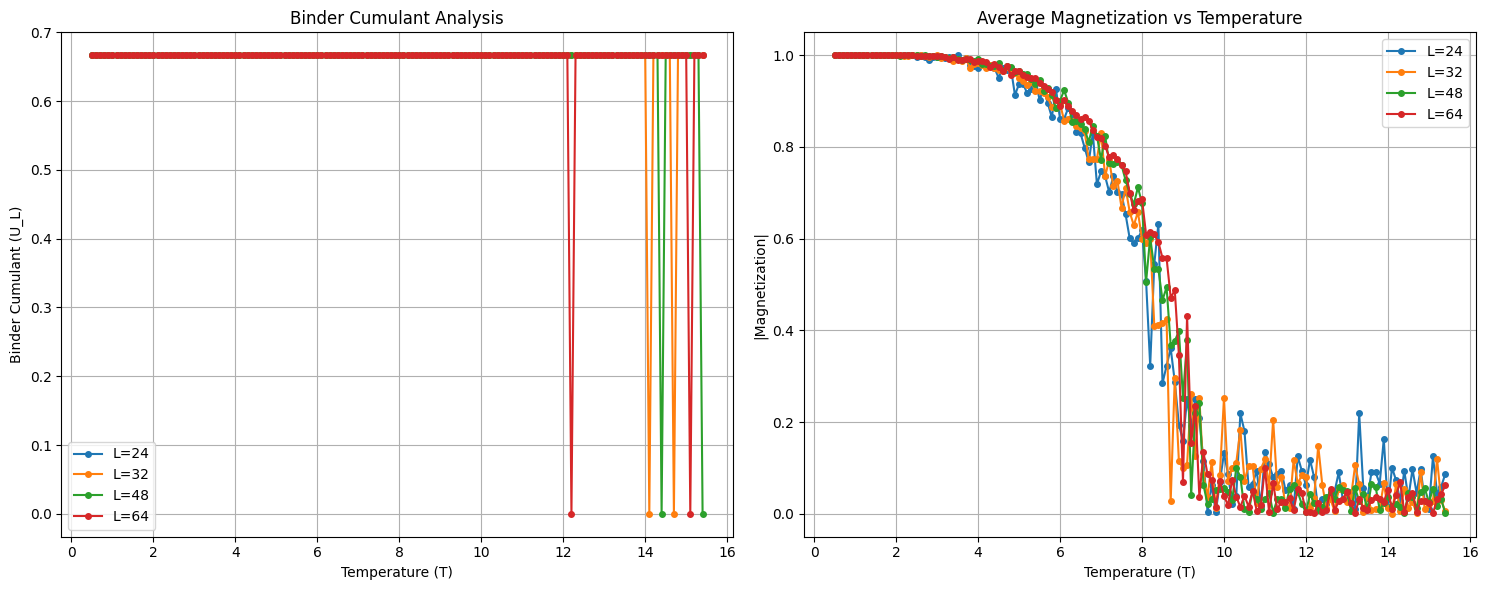


Estimating critical temperature...
Intersection between L=24 and L=32: T_c = 0.5075, U* = 0.6667
Intersection between L=24 and L=48: T_c = 0.5075, U* = 0.6667
Intersection between L=24 and L=64: T_c = 0.5075, U* = 0.6667
Intersection between L=32 and L=48: T_c = 0.5075, U* = 0.6667
Intersection between L=32 and L=64: T_c = 0.5075, U* = 0.6667
Intersection between L=48 and L=64: T_c = 0.5075, U* = 0.6667

Final estimates:
Critical temperature (T_c) = 0.5075 ± 0.0000
Universal Binder cumulant (U*) = 0.6667 ± 0.0000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import os

class BinderCumulantAnalysis:
    def __init__(self):
        """Initialize the analysis"""
        self.system_sizes = []
        self.temperatures = set()
        self.magnetizations = {}
        self.binder_data = {}

    def calculate_magnetization(self, lattice):
        """Calculate magnetization per spin without taking absolute value"""
        return np.mean(lattice)

    def calculate_binder_cumulant(self, magnetizations):
        """
        Calculate Binder cumulant U_L = 1 - <m^4>/(3<m^2>^2)
        Input magnetizations should be raw (not absolute) values
        """
        m2 = np.mean(magnetizations**2)
        m4 = np.mean(magnetizations**4)

        if m2 < 1e-10:  # Avoid division by zero
            return 0.0

        denominator = 3 * m2**2
        if denominator < 1e-10:
            return 0.0

        return 1.0 - m4/denominator

    def process_single_file(self, filename):
        """Process a single npz file for a given system size"""
        data = np.load(filename)
        X = data['X']  # Lattice configurations
        y = data['y']  # Temperatures

        L = X.shape[1]  # System size
        print(f"\nProcessing L = {L}")

        if L not in self.system_sizes:
            self.system_sizes.append(L)
            self.magnetizations[L] = {}

        unique_temps = np.unique(y)
        self.temperatures.update(unique_temps)

        # For each temperature, calculate magnetization
        for T in unique_temps:
            config_indices = np.where(y == T)[0]
            # Store raw magnetization values (not absolute)
            m_values = np.array([self.calculate_magnetization(X[i]) for i in config_indices])
            self.magnetizations[L][T] = m_values

    def process_all_files(self, filenames):
        """Process all data files"""
        print("Starting data processing...")
        for filename in filenames:
            if os.path.exists(filename):
                self.process_single_file(filename)
            else:
                print(f"Warning: File {filename} not found")

        self.temperatures = sorted(list(self.temperatures))
        self.system_sizes.sort()

    def calculate_all_binder_cumulants(self):
        """Calculate Binder cumulants for all system sizes and temperatures"""
        print("\nCalculating Binder cumulants...")

        for L in self.system_sizes:
            self.binder_data[L] = []
            for T in self.temperatures:
                if T in self.magnetizations[L]:
                    UL = self.calculate_binder_cumulant(self.magnetizations[L][T])
                    self.binder_data[L].append(UL)
                else:
                    self.binder_data[L].append(np.nan)

    def plot_analysis(self, save_path=None):
        """Create visualization plots"""
        plt.figure(figsize=(15, 6))

        # Plot 1: Binder cumulants
        plt.subplot(1, 2, 1)
        for L in self.system_sizes:
            plt.plot(self.temperatures, self.binder_data[L],
                    'o-', label=f'L={L}', markersize=4)

        plt.xlabel('Temperature (T)')
        plt.ylabel('Binder Cumulant (U_L)')
        plt.title('Binder Cumulant Analysis')
        plt.legend()
        plt.grid(True)

        # Plot 2: Magnetization
        plt.subplot(1, 2, 2)
        for L in self.system_sizes:
            avg_mag = []
            for T in self.temperatures:
                if T in self.magnetizations[L]:
                    # Take absolute value only for visualization
                    avg_mag.append(np.mean(np.abs(self.magnetizations[L][T])))
                else:
                    avg_mag.append(0.0)

            plt.plot(self.temperatures, avg_mag,
                    'o-', label=f'L={L}', markersize=4)

        plt.xlabel('Temperature (T)')
        plt.ylabel('|Magnetization|')
        plt.title('Average Magnetization vs Temperature')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        if save_path:
            plt.savefig(os.path.join(save_path, 'binder_analysis.png'),
                       dpi=300, bbox_inches='tight')
        plt.show()

    def find_intersection_points(self, L1, L2):
        """Find intersection points between Binder cumulants for two system sizes"""
        temps = self.temperatures
        U1 = self.binder_data[L1]
        U2 = self.binder_data[L2]

        # Use interpolation to find crossings
        f1 = interp1d(temps, U1, kind='cubic')
        f2 = interp1d(temps, U2, kind='cubic')

        # Look for intersections on a finer grid
        t_fine = np.linspace(min(temps), max(temps), 1000)
        diff = f1(t_fine) - f2(t_fine)

        intersections = []
        for i in range(len(t_fine)-1):
            if diff[i] * diff[i+1] <= 0:
                t_cross = (t_fine[i] + t_fine[i+1])/2
                U_cross = (f1(t_cross) + f2(t_cross))/2
                intersections.append((t_cross, U_cross))

        return intersections

    def estimate_critical_temperature(self):
        """Estimate critical temperature from Binder cumulant intersections"""
        print("\nEstimating critical temperature...")
        all_intersections = []

        # Find intersections between all pairs of system sizes
        for i, L1 in enumerate(self.system_sizes[:-1]):
            for L2 in self.system_sizes[i+1:]:
                intersections = self.find_intersection_points(L1, L2)
                if intersections:
                    # Take only the first intersection if multiple exist
                    T_c, U_c = intersections[0]
                    all_intersections.append((T_c, U_c))
                    print(f"Intersection between L={L1} and L={L2}: T_c = {T_c:.4f}, U* = {U_c:.4f}")

        if all_intersections:
            T_c_values = [T for T, _ in all_intersections]
            U_values = [U for _, U in all_intersections]

            T_c = np.mean(T_c_values)
            T_c_err = np.std(T_c_values)
            U_star = np.mean(U_values)
            U_star_err = np.std(U_values)

            print(f"\nFinal estimates:")
            print(f"Critical temperature (T_c) = {T_c:.4f} ± {T_c_err:.4f}")
            print(f"Universal Binder cumulant (U*) = {U_star:.4f} ± {U_star_err:.4f}")

            return T_c, T_c_err, U_star, U_star_err
        else:
            print("Warning: No intersections found!")
            return None, None, None, None

def run_binder_analysis(file_pattern, save_dir=None):
    """Run complete Binder cumulant analysis"""
    # System sizes to analyze
    system_sizes = [24, 32, 48, 64]  # Adjust these to match your data
    filenames = [file_pattern.format(L) for L in system_sizes]

    # Check for existing files
    existing_files = [f for f in filenames if os.path.exists(f)]
    if not existing_files:
        raise FileNotFoundError("No data files found!")

    # Initialize and run analysis
    analyzer = BinderCumulantAnalysis()
    analyzer.process_all_files(existing_files)
    analyzer.calculate_all_binder_cumulants()
    analyzer.plot_analysis(save_dir)

    return analyzer, analyzer.estimate_critical_temperature()

if __name__ == "__main__":
    # File pattern and output directory
    file_pattern = "LRIM_FT_{}L_modified_data.npz"  # Adjust to match your file naming
    save_directory = "binder_analysis_results"

    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    try:
        # Run analysis
        analyzer, results = run_binder_analysis(file_pattern, save_directory)

        # Save results if successful
        if results is not None:
            T_c, T_c_err, U_star, U_star_err = results
            with open(os.path.join(save_directory, 'results.txt'), 'w') as f:
                f.write(f"Critical Temperature (T_c) = {T_c:.4f} ± {T_c_err:.4f}\n")
                f.write(f"Universal Binder Cumulant (U*) = {U_star:.4f} ± {U_star_err:.4f}\n")
                f.write(f"\nAnalyzed System Sizes: {analyzer.system_sizes}\n")
                f.write(f"Temperature Range: {min(analyzer.temperatures):.4f} to {max(analyzer.temperatures):.4f}\n")

    except Exception as e:
        print(f"Error during analysis: {str(e)}")

In [ ]:
def estimate_critical_temperature(self):
    intersection_temps = []
    intersection_UL = []

    for i, L1 in enumerate(self.system_sizes[:-1]):
        for L2 in self.system_sizes[i+1:]):
            valid_indices = ~np.isnan(self.binder_data[L1]) & ~np.isnan(self.binder_data[L2])
            temps = np.array(self.temperatures)[valid_indices]
            UL1 = np.array(self.binder_data[L1])[valid_indices]
            UL2 = np.array(self.binder_data[L2])[valid_indices]

            if len(temps) > 3:
                f1 = interp1d(temps, UL1, kind='cubic')
                f2 = interp1d(temps, UL2, kind='cubic')

                t_dense = np.linspace(temps[0], temps[-1], 5000)
                diff = f1(t_dense) - f2(t_dense)

                # Calculate derivatives for slope comparison
                df1 = np.gradient(f1(t_dense), t_dense)
                df2 = np.gradient(f2(t_dense), t_dense)

                for j in range(len(t_dense)-1):
                    if diff[j] * diff[j+1] < 0:
                        # Crossing point
                        t_cross = (t_dense[j] + t_dense[j+1])/2

                        # Check crossing angle
                        slope1 = df1[j]
                        slope2 = df2[j]
                        angle = np.abs(np.arctan(slope1) - np.arctan(slope2))

                        # Only accept crossings with significant angle
                        if angle > 0.1:  # minimum angle threshold
                            intersection_temps.append(t_cross)
                            intersection_UL.append((f1(t_cross) + f2(t_cross))/2)

    if intersection_temps:
        intersection_temps = np.array(intersection_temps)
        intersection_UL = np.array(intersection_UL)

        # Filter outliers using IQR method
        Q1 = np.percentile(intersection_temps, 25)
        Q3 = np.percentile(intersection_temps, 75)
        IQR = Q3 - Q1
        mask = (intersection_temps >= Q1 - 1.5*IQR) & (intersection_temps <= Q3 + 1.5*IQR)

        filtered_temps = intersection_temps[mask]
        filtered_UL = intersection_UL[mask]

        if len(filtered_temps) > 0:
            Tc = np.mean(filtered_temps)
            Tc_err = np.std(filtered_temps)
            UL_star = np.mean(filtered_UL)
            UL_star_err = np.std(filtered_UL)

            print(f"Critical temperature (Tc) = {Tc:.4f} ± {Tc_err:.4f}")
            print(f"Universal Binder cumulant (U*) = {UL_star:.4f} ± {UL_star_err:.4f}")
            print(f"Number of valid intersections: {len(filtered_temps)}")

            return Tc, Tc_err, UL_star, UL_star_err

    print("Warning: No valid intersections found!")
    return None, None, None, None

## This is the working code for Binder cumulant method of finding Tc.

Starting data processing...

Processing L = 64
Found 1500 configurations
Temperature range: 0.500 to 15.400

Calculating Binder cumulants...


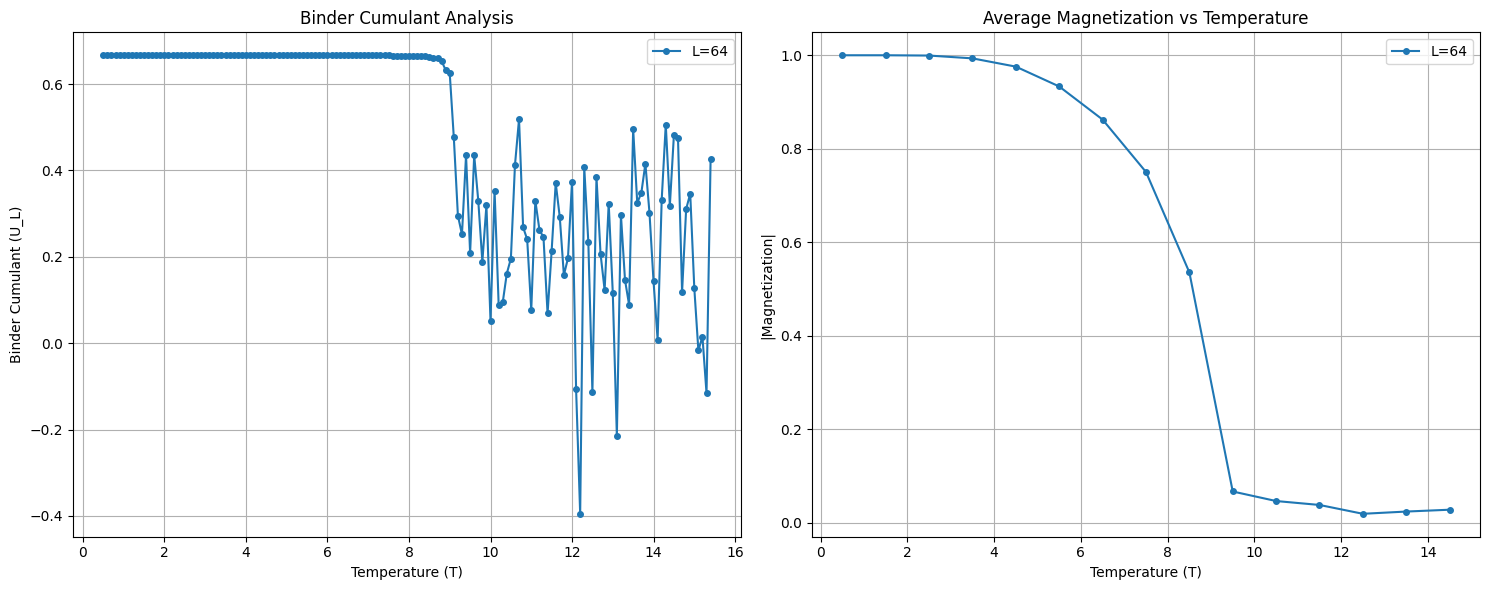


Error during analysis: unsupported format string passed to NoneType.__format__


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import os

class CompleteBinder:
    def __init__(self):
        self.system_sizes = []
        self.temperatures = set()
        self.magnetizations = {}
        self.binder_data = {}

    def calculate_binder_moment(self, magnetizations):
        """
        Calculate Binder cumulant U_L = 1 - <m^4>/(3<m^2>^2)
        with proper error handling
        """
        try:
            m2 = np.mean(magnetizations**2)
            m4 = np.mean(magnetizations**4)

            if m2 < 1e-10:  # Check for very small values
                return 0.0

            denominator = 3 * m2**2
            if denominator < 1e-10:  # Another zero check
                return 0.0

            UL = 1.0 - (m4 / denominator)

            if np.isnan(UL) or np.isinf(UL):
                return 0.0

            return UL
        except Exception as e:
            print(f"Error in Binder calculation: {str(e)}")
            return 0.0

    def process_single_file(self, filename):
        data = np.load(filename)
        X = data['X']  # Lattice configurations
        y = data['y']  # Temperatures

        L = X.shape[1]  # System size
        print(f"\nProcessing L = {L}")
        print(f"Found {len(X)} configurations")
        print(f"Temperature range: {np.min(y):.3f} to {np.max(y):.3f}")

        if L not in self.system_sizes:
            self.system_sizes.append(L)
            self.magnetizations[L] = {}

        unique_temps = np.unique(y)
        self.temperatures.update(unique_temps)

        # Process each temperature
        for T in unique_temps:
            config_indices = np.where(y == T)[0]
            m_values = np.array([np.mean(X[i]) for i in config_indices])
            self.magnetizations[L][T] = m_values

    def process_all_files(self, filenames):
        print("Starting data processing...")
        for filename in filenames:
            if os.path.exists(filename):
                self.process_single_file(filename)
            else:
                print(f"Warning: File {filename} not found.")

        self.temperatures = sorted(list(self.temperatures))
        self.system_sizes.sort()

    def calculate_binder_cumulants(self):
        print("\nCalculating Binder cumulants...")
        for L in self.system_sizes:
            self.binder_data[L] = []
            for T in self.temperatures:
                if T in self.magnetizations[L]:
                    UL = self.calculate_binder_moment(self.magnetizations[L][T])
                    self.binder_data[L].append(UL)
                else:
                    self.binder_data[L].append(0.0)

    def plot_analysis(self, save_path=None, thin_factor=10):
        plt.figure(figsize=(15, 6))

        # Plot 1: Binder cumulants
        plt.subplot(1, 2, 1)
        for L in self.system_sizes:
            plt.plot(self.temperatures, self.binder_data[L],
                    'o-', label=f'L={L}', markersize=4)

        plt.xlabel('Temperature (T)')
        plt.ylabel('Binder Cumulant (U_L)')
        plt.title('Binder Cumulant Analysis')
        plt.legend()
        plt.grid(True)

        # Plot 2: Magnetization with thinning
        plt.subplot(1, 2, 2)
        for L in self.system_sizes:
            avg_mag = []
            for T in self.temperatures:
                if T in self.magnetizations[L]:
                    # Use absolute value for magnetization plot
                    avg_mag.append(np.mean(np.abs(self.magnetizations[L][T])))
                else:
                    avg_mag.append(0.0)

            # Thin the data for clearer plotting
            temps_thin = np.array(self.temperatures)[::thin_factor]
            mag_thin = np.array(avg_mag)[::thin_factor]

            plt.plot(temps_thin, mag_thin,
                    'o-', label=f'L={L}', markersize=4)

        plt.xlabel('Temperature (T)')
        plt.ylabel('|Magnetization|')
        plt.title('Average Magnetization vs Temperature')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        if save_path:
            plt.savefig(os.path.join(save_path, 'analysis_plots.png'),
                       dpi=300, bbox_inches='tight')
        plt.show()

    def estimate_critical_temperature(self):
        intersection_temps = []
        intersection_UL = []

        # Find intersections between all pairs of system sizes
        for i, L1 in enumerate(self.system_sizes[:-1]):
            for L2 in self.system_sizes[i+1:]:
                # Get valid data points
                UL1 = np.array(self.binder_data[L1])
                UL2 = np.array(self.binder_data[L2])

                if len(self.temperatures) > 3:
                    try:
                        # Create interpolation functions
                        f1 = interp1d(self.temperatures, UL1, kind='cubic')
                        f2 = interp1d(self.temperatures, UL2, kind='cubic')

                        # Generate dense temperature points
                        t_dense = np.linspace(min(self.temperatures),
                                           max(self.temperatures), 5000)

                        # Find intersection points
                        vals1 = f1(t_dense)
                        vals2 = f2(t_dense)
                        diff = vals1 - vals2

                        for j in range(len(t_dense)-1):
                            if diff[j] * diff[j+1] <= 0:  # Sign change indicates crossing
                                t_cross = (t_dense[j] + t_dense[j+1])/2
                                intersection_temps.append(t_cross)
                                intersection_UL.append((f1(t_cross) + f2(t_cross))/2)

                    except Exception as e:
                        print(f"Error in intersection finding for L1={L1}, L2={L2}: {str(e)}")

        if intersection_temps:
            intersection_temps = np.array(intersection_temps)
            intersection_UL = np.array(intersection_UL)

            # Filter out outliers using IQR method
            Q1 = np.percentile(intersection_temps, 25)
            Q3 = np.percentile(intersection_temps, 75)
            IQR = Q3 - Q1
            mask = (intersection_temps >= Q1 - 1.5*IQR) & (intersection_temps <= Q3 + 1.5*IQR)

            filtered_temps = intersection_temps[mask]
            filtered_UL = intersection_UL[mask]

            if len(filtered_temps) > 0:
                Tc = np.mean(filtered_temps)
                Tc_err = np.std(filtered_temps)
                UL_star = np.mean(filtered_UL)
                UL_star_err = np.std(filtered_UL)

                print(f"\nResults:")
                print(f"Critical temperature (Tc) = {Tc:.4f} ± {Tc_err:.4f}")
                print(f"Universal Binder cumulant (U*) = {UL_star:.4f} ± {UL_star_err:.4f}")
                print(f"Number of valid intersections: {len(filtered_temps)}")

                return Tc, Tc_err, UL_star, UL_star_err

        print("\nWarning: No valid intersections found!")
        return None, None, None, None

def run_complete_analysis(file_pattern, save_dir=None):
    """Run the complete Binder cumulant analysis"""
    system_sizes = [64]  # Adjust these to match your data
    filenames = [file_pattern.format(L) for L in system_sizes]

    # Check for existing files
    existing_files = [f for f in filenames if os.path.exists(f)]
    if not existing_files:
        raise FileNotFoundError("No data files found!")

    # Initialize and run analysis
    analyzer = CompleteBinder()
    analyzer.process_all_files(existing_files)
    analyzer.calculate_binder_cumulants()
    analyzer.plot_analysis(save_dir, thin_factor=10)

    return analyzer, analyzer.estimate_critical_temperature()

if __name__ == "__main__":
    # Set up file pattern and output directory
    file_pattern = "LRIM_FT_{}L_maxepochs_M.npz"  # Adjust this to match your file naming
    save_directory = "binder_analysis_results_4"

    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    try:
        # Run the analysis
        analyzer, results = run_complete_analysis(file_pattern, save_directory)

        # Save results if successful
        if results is not None:
            Tc, Tc_err, UL_star, UL_star_err = results
            with open(os.path.join(save_directory, 'results.txt'), 'w') as f:
                f.write(f"Critical Temperature (Tc) = {Tc:.4f} ± {Tc_err:.4f}\n")
                f.write(f"Universal Binder Cumulant (U*) = {UL_star:.4f} ± {UL_star_err:.4f}\n")
                f.write(f"\nAnalyzed System Sizes: {analyzer.system_sizes}\n")
                f.write(f"Temperature Range: {min(analyzer.temperatures):.4f} to {max(analyzer.temperatures):.4f}\n")

    except Exception as e:
        print(f"Error during analysis: {str(e)}")

## This is the working code for Thermal Analysis.

Starting thermal analysis...

Processing L = 64


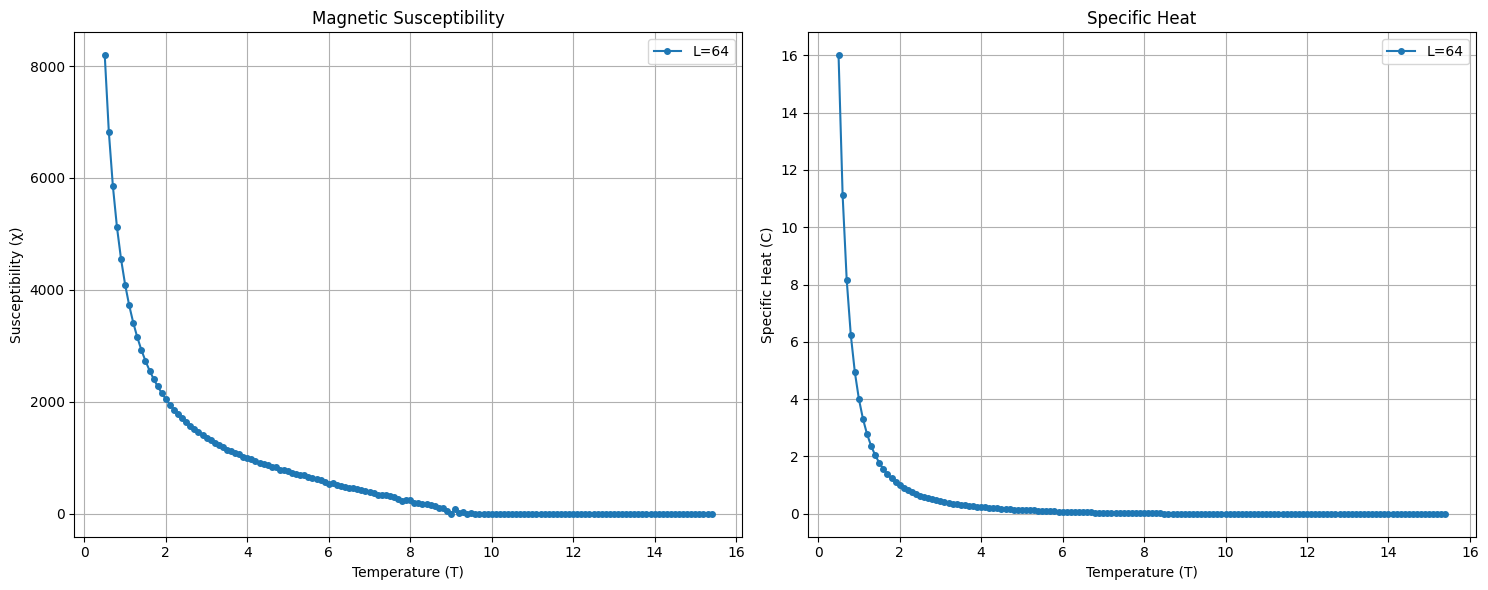

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import os
class ThermalAnalysis:
    def __init__(self):
        self.system_sizes = []
        self.temperatures = set()
        self.susceptibility = {}
        self.specific_heat = {}

    def process_single_file(self, filename):
        data = np.load(filename)
        X = data['X']  # Lattice configurations
        y = data['y']  # Temperatures

        L = X.shape[1]  # System size
        print(f"\nProcessing L = {L}")

        if L not in self.system_sizes:
            self.system_sizes.append(L)
            self.susceptibility[L] = {}
            self.specific_heat[L] = {}

        unique_temps = np.unique(y)
        self.temperatures.update(unique_temps)

        # Calculate for each temperature
        for T in unique_temps:
            config_indices = np.where(y == T)[0]
            lattice = X[config_indices[0]]  # Using first configuration at this T

            # Calculate magnetization and energy
            M = np.mean(lattice)
            E = self.calculate_energy(lattice)

            # Calculate susceptibility: χ = (N/T)⟨m²⟩
            susceptibility = (L*L/T) * (M**2)
            # susceptibility = (n1*M2 - n2*M1*M1)*iT

            # Calculate specific heat: C = (1/T²)[⟨E²⟩ - ⟨E⟩²]
            specific_heat = (1/(T*T)) * (E**2)

            self.susceptibility[L][T] = susceptibility
            self.specific_heat[L][T] = specific_heat

    def calculate_energy(self, lattice):
        """Calculate energy for a 2D lattice with periodic boundary conditions"""
        L = lattice.shape[0]
        E = 0.0

        # Sum over all nearest neighbors
        for i in range(L):
            for j in range(L):
                spin = lattice[i,j]
                # Right neighbor
                right = lattice[i,(j+1)%L]
                # Down neighbor
                down = lattice[(i+1)%L,j]
                E += -1.0 * spin * (right + down)

        return E/(L*L)  # Energy per spin

    def process_all_files(self, filenames):
        print("Starting thermal analysis...")
        for filename in filenames:
            if os.path.exists(filename):
                self.process_single_file(filename)
            else:
                print(f"Warning: File {filename} not found")

        self.temperatures = sorted(list(self.temperatures))
        self.system_sizes.sort()

    def plot_analysis(self, save_path=None):
        plt.figure(figsize=(15, 6))

        # Plot susceptibility
        plt.subplot(1, 2, 1)
        for L in self.system_sizes:
            chi_values = [self.susceptibility[L][T] for T in self.temperatures]
            plt.plot(self.temperatures, chi_values, 'o-', label=f'L={L}', markersize=4)

        plt.xlabel('Temperature (T)')
        plt.ylabel('Susceptibility (χ)')
        plt.title('Magnetic Susceptibility')
        plt.legend()
        plt.grid(True)

        # Plot specific heat
        plt.subplot(1, 2, 2)
        for L in self.system_sizes:
            cv_values = [self.specific_heat[L][T] for T in self.temperatures]
            plt.plot(self.temperatures, cv_values, 'o-', label=f'L={L}', markersize=4)

        plt.xlabel('Temperature (T)')
        plt.ylabel('Specific Heat (C)')
        plt.title('Specific Heat')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        if save_path:
            plt.savefig(os.path.join(save_path, 'thermal_analysis.png'),
                       dpi=300, bbox_inches='tight')
        plt.show()

def run_thermal_analysis(file_pattern, save_dir=None):
    system_sizes = [64]  # Adjust to match your data
    filenames = [file_pattern.format(L) for L in system_sizes]

    analyzer = ThermalAnalysis()
    analyzer.process_all_files(filenames)
    analyzer.plot_analysis(save_dir)

    return analyzer

if __name__ == "__main__":
    file_pattern = "LRIM_FT_{}L_modified_data.npz"
    save_directory = "thermal_analysis_results"

    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    try:
        analyzer = run_thermal_analysis(file_pattern, save_directory)
    except Exception as e:
        print(f"Error during analysis: {str(e)}")

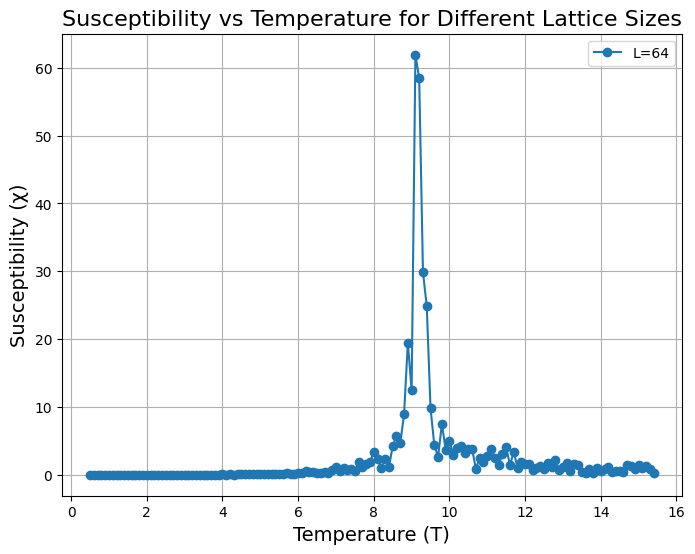

L = 64, Tc ≈ 9.10


In [32]:
# Code for susceptibility

import numpy as np
import matplotlib.pyplot as plt

def calcMagnetization(lattice):
    """Compute the magnetization of a given lattice configuration."""
    return np.sum(lattice) / (lattice.shape[0] * lattice.shape[1])  # Normalize by system size

# Define lattice sizes
L_values = [64]
Tc_values = []

plt.figure(figsize=(8, 6))

# Loop over different lattice sizes
for L in L_values:
    filename = f"LRIM_FT_{L}L_maxepochs_M.npz"  # File format

    # Load data
    try:
        data = np.load(filename)
        X = data["X"]  # Shape: (num_samples, L, L)
        Y = data["y"]  # Corresponding temperatures (num_samples,)
    except FileNotFoundError:
        print(f"File {filename} not found. Skipping L={L}.")
        continue

    unique_temperatures = np.sort(np.unique(Y))
    susceptibility = []

    # Compute susceptibility at each temperature
    for T in unique_temperatures:
        indices = np.where(Y == T)[0]
        magnetizations = np.array([abs(calcMagnetization(X[i])) for i in indices])

        M_avg = np.mean(magnetizations)
        M2_avg = np.mean(magnetizations**2)

        chi = (M2_avg - M_avg**2) * (L * L)  # Multiply by system size
        susceptibility.append(chi)

    # Find the temperature corresponding to max susceptibility (Tc)
    Tc_index = np.argmax(susceptibility)
    Tc = unique_temperatures[Tc_index]
    Tc_values.append((L, Tc))

    # Plot Susceptibility vs Temperature
    plt.plot(unique_temperatures, susceptibility, marker='o', linestyle='-', label=f"L={L}")

# Add labels and legend
plt.xlabel("Temperature (T)", fontsize=14)
plt.ylabel("Susceptibility (χ)", fontsize=14)
plt.title("Susceptibility vs Temperature for Different Lattice Sizes", fontsize=16)
plt.legend()
plt.grid()

# Show the plot
plt.show()

# Print Tc values for different L
for L, Tc in Tc_values:
    print(f"L = {L}, Tc ≈ {Tc:.2f}")


-0.40185546875


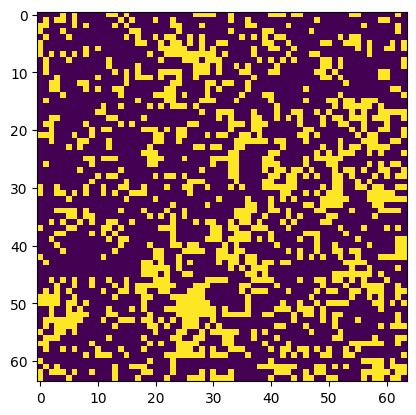

In [43]:
plt.imshow(X[np.where(Y == 8.9)[0][2]])
print(np.sum(X[np.where(Y == 8.9)[0][3]])/(64*64))